#Queistion 1- Part b & c


In [33]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot
from keras import backend
from keras.models import load_model
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt

>Discriminatir & Custom Activation 

In [2]:
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

def define_discriminator(in_shape=(28,28,1), n_classes=10):
	in_image = layers.Input(shape=in_shape)
	disc = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
	disc = layers.LeakyReLU(alpha=0.2)(disc)
	disc = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(disc)
	disc = layers.LeakyReLU(alpha=0.2)(disc)
	disc = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(disc)
	disc = layers.LeakyReLU(alpha=0.2)(disc)
	disc = layers.Flatten()(disc)
	disc = layers.Dropout(0.4)(disc)
	disc = layers.Dense(n_classes)(disc)
	c_out_layer = layers.Activation('softmax')(disc)
	c_model = models.Model(in_image, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
	d_out_layer = layers.Lambda(custom_activation)(disc)
	d_model = models.Model(in_image, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return d_model, c_model

>Generator 

In [3]:
def define_generator(latent_dim):

	in_lat = layers.Input(shape=(latent_dim,))
	n_nodes = 128 * 7 * 7
	gen = layers.Dense(n_nodes)(in_lat)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	gen = layers.Reshape((7, 7, 128))(gen)
	gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	out_layer = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	model = models.Model(in_lat, out_layer)
	return model


>GAN

In [4]:
def define_gan(g_model, d_model):

	d_model.trainable = False
	gan_output = d_model(g_model.output)
	model = models.Model(g_model.input, gan_output)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

>load real samples

In [5]:
def load_real_samples():

	(trainX, trainy), (_, _) = load_data()
	X = np.expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	return [X, trainy]

>select supervised samples

In [6]:
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
	X, y = dataset
	X_list, y_list = list(), list()
	n_per_class = int(n_samples / n_classes)
	for i in range(n_classes):
		X_with_class = X[y == i]
		ix = randint(0, len(X_with_class), n_per_class)
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return np.asarray(X_list), np.asarray(y_list)

> generate_real_sample

In [7]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = np.ones((n_samples, 1))
	return [X, labels], y

>generate_latent_points

In [8]:
def generate_latent_points(latent_dim, n_samples):
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

>generate_fake_samples

In [9]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict(z_input)
	y = np.zeros((n_samples, 1))
	return images, y

>summarize_performance

In [10]:
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	X = (X + 1) / 2.0
	for i in range(100):
		pyplot.subplot(10, 10, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the classifier model
	filename3 = 'c_model_%04d.h5' % (step+1)
	c_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

>Training

In [11]:
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
	X_sup, y_sup = select_supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	for i in range(n_steps):
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
		[X_real, _], y_real = generate_real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)

		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)

		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))

		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, c_model, latent_dim, dataset)



> Run

In [13]:
latent_dim = 100
d_model, c_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>7028, c[0.001,100], d[0.715,0.763], g[1.378]
>7029, c[0.001,100], d[0.712,0.630], g[1.407]
>7030, c[0.001,100], d[0.982,0.788], g[1.207]
>7031, c[0.001,100], d[0.642,0.793], g[1.060]
>7032, c[0.001,100], d[0.602,0.738], g[1.256]
>7033, c[0.001,100], d[0.948,0.795], g[1.153]
>7034, c[0.001,100], d[0.580,0.568], g[1.232]
>7035, c[0.001,100], d[0.777,0.589], g[1.235]
>7036, c[0.003,100], d[0.669,0.849], g[1.065]
>7037, c[0.001,100], d[0.516,0.707], g[1.134]
>7038, c[0.001,100], d[0.919,0.685], g[1.107]
>7039, c[0.001,100], d[0.941,1.003], g[1.148]
>7040, c[0.003,100], d[0.752,0.678], g[1.141]
>7041, c[0.001,100], d[0.691,0.706], g[1.206]
>7042, c[0.002,100], d[0.739,0.941], g[1.138]
>7043, c[0.001,100], d[0.860,0.704], g[1.273]
>7044, c[0.001,100], d[0.895,0.817], g[1.251]
>7045, c[0.001,100], d[0.683,0.816], g[1.225]
>7046, c[0.001,100], d[0.647,0.688], g[1.080]
>7047, c[0.001,100], d[0.710,0.679], g[1.294]
>7048, c[0.001,100], d[0.735,

In [16]:
model = load_model('c_model_12000.h5')
(trainX, trainy), (testX, testy) = load_data()
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX = (trainX - 127.5) / 127.5
testX = (testX - 127.5) / 127.5
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
print('Train Accuracy: %.3f%%' % (train_acc * 100))
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

Train Accuracy: 92.935%
Test Accuracy: 93.310%


# Part C- Classifier

In [45]:
d_model, c_model = define_discriminator()
dataset = load_real_samples()
X_sup, y_sup = select_supervised_samples(dataset)
[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], 100)
history = c_model.fit(Xsup_real, ysup_real, epochs = 20, batch_size = 100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(60000, 28, 28, 1) (60000,)
Epoch 1/20
1/1 [==============================] - 0s 352ms/step - loss: 2.3120 - accuracy: 0.1200
Epoch 2/20
1/1 [==============================] - 0s 16ms/step - loss: 2.2849 - accuracy: 0.1300
Epoch 3/20
1/1 [==============================] - 0s 15ms/step - loss: 2.2667 - accuracy: 0.1700
Epoch 4/20
1/1 [==============================] - 0s 16ms/step - loss: 2.2561 - accuracy: 0.2200
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 2.2365 - accuracy: 0.2500
Epoch 6/20
1/1 [==============================] - 0s 16ms/step - loss: 2.2102 - accuracy: 0.4400
Epoch 7/20
1/1 [==============================] - 0s 17ms/step - loss: 2.1859 - accuracy: 0.4000
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 2.1612 - accuracy: 0.4500
Epoch 9/20
1/1 [==============================] - 0s 16ms/step - loss: 2.1371 - accuracy: 0.4800
Epoch 10/20
1/1 [==============================] - 0s 16ms/step - loss: 2.1164 - accuracy: 0.5100


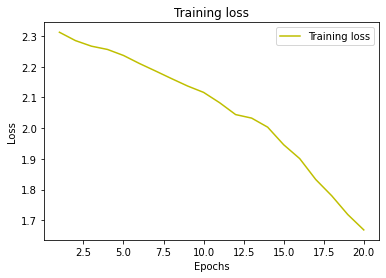

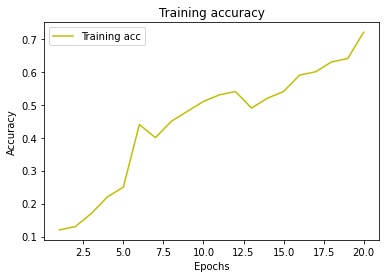

In [46]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [47]:
(_, _), (test_X, test_y) = load_data()
test_X = np.expand_dims(test_X, axis=-1)
test_X = test_X.astype('float32')
test_X = test_X /255.
_, test_acc = c_model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

Test Accuracy: 43.050%
